### Multipoint Calibration

We want to build upon the phase calibration explored in a previous example by 
calibrating at many points simultaneously. `slmsuite` is equipped with two methods
for this:

- A version of the superpixel-based calibration explored before, which interferes many calibration points simultaneously,
- Zernike-based wavefront calibration, where aberration is iteratively subtracted from a Zernike spot array.


#### Initialization

To start, we initialize our system:

In [1]:
# Header. This is hidden from sphinx with the json metadata:
#   {"nbsphinx":"hidden"}

# ipython configuration (reloads source code automatically and plots inline)
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os, sys
import numpy as np

import warnings
warnings.filterwarnings("ignore")

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc('image', cmap='Blues')

# Add slmsuite to the python path (For the case where it isn't installed via pip).
# slmsuite-examples is assumed to be installed in the same directory as slmsuite.
sys.path.append(os.path.join(os.getcwd(), '../../slmsuite'))

from slmsuite.hardware.slms.santec import Santec
from slmsuite.hardware.cameras.alliedvision import AlliedVision
from slmsuite.hardware.cameraslms import FourierSLM

from slmsuite.holography.toolbox.phase import blaze, zernike_sum

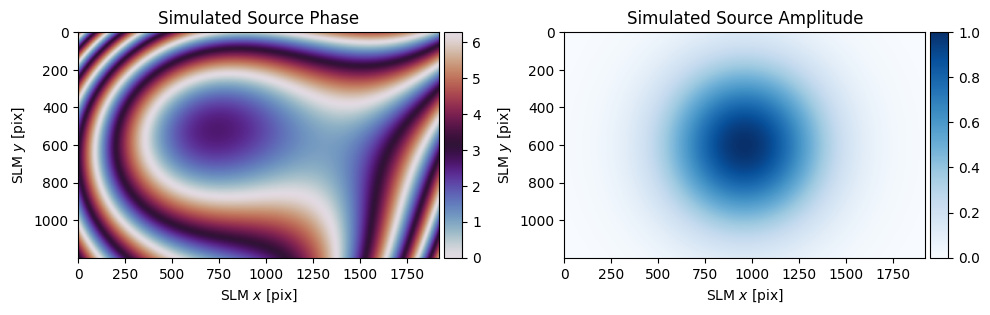

In [2]:
# **README**                        (This cell is hidden from readthedocs rendering)
# If you're reading this, you might have gotten an error from loading physical
# hardware in the next cell, but that doesn't mean you can't run this notebook!
# This cell loads virtual hardware. You can proceed to the Simple Holography section.
from slmsuite.hardware.cameraslms import FourierSLM
from slmsuite.hardware.slms.simulated import SimulatedSLM
from slmsuite.hardware.cameras.simulated import SimulatedCamera

# Make the SLM and camera.
slm = SimulatedSLM((1920, 1200), pitch_um=(8,8))
phase_abberation = zernike_sum(
    slm,
    indices=(3, 4, 5, 7, 8),
    weights=(1, -2, 3, 1, 1),
    aperture=None,
    use_mask=False
)
slm.set_source_analytic(                        # Program the virtual source.
    phase_offset=phase_abberation,
    sim=True
)
slm.plot_source(sim=True)
slm.set_source_analytic()

cam = SimulatedCamera(slm, (1440, 1100), pitch_um=(4,4), gain=50)

# Tie the camera and SLM together with an analytic Fourier calibration.
fs = FourierSLM(cam, slm)
M, b = fs.fourier_calibration_build(
    f_eff=80000.,                               # f_eff of 80000 wavelengths or 80 mm with the default 1 um wavelength
    theta=5 * np.pi / 180,                      # Slight rotation for fun.
)
fs.fourier_calibrate_analytic(M, b)

In [3]:
slm = Santec(slm_number=1, display_number=2, wav_um=.633, settle_time_s=.5); print()
cam = AlliedVision(serial="02C5V", fliplr=True)
fs = FourierSLM(cam, slm)

Santec slm_number=1 initializing... success
Looking for display_number=2... success
Opening LCOS-SLM,SOC,8001,2018021001... success

vimba initializing... success
Looking for cameras... success
vimba sn '02C5V' initializing... success


  0%|          | 0/10 [00:00<?, ?it/s]

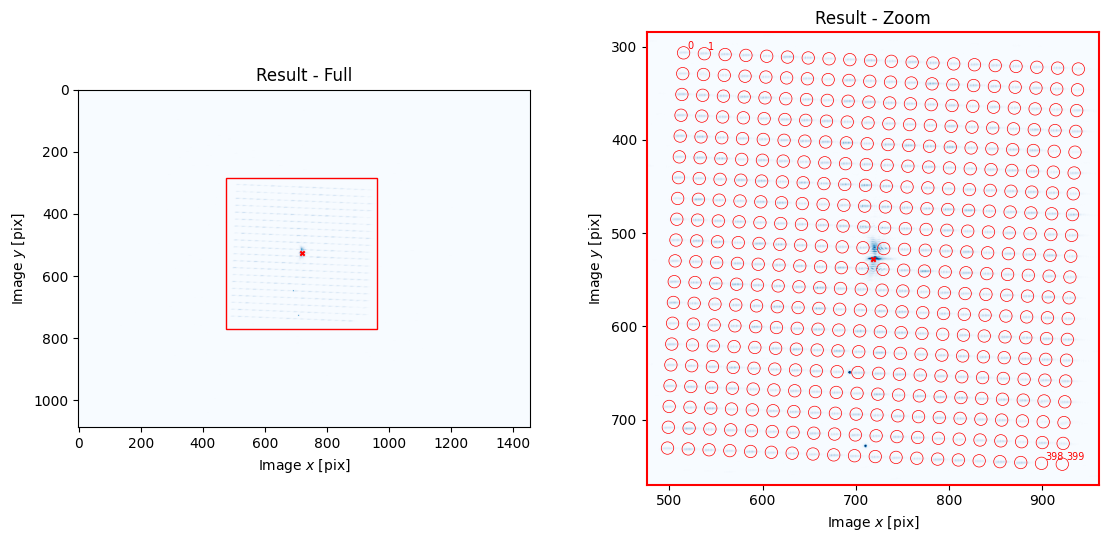

{'M': array([[28829.15320556, -1174.18854042],
        [ 1178.24291723, 28860.19947361]]),
 'b': array([[718.36678208],
        [527.26774779]]),
 'a': array([[-8.76122968e-21],
        [ 5.60718699e-19]]),
 '__version__': '0.1.0',
 '__time__': '2024-07-26 00:25:53.797717',
 '__timestamp__': 1721967953.797717,
 '__meta__': {'camera': '02C5V', 'slm': '2018021001'}}

In [4]:
cam.set_exposure(.02)
fs.fourier_calibrate(20, 20, plot=True)

#### Multipoint Calibration Grid

When calibrating at many points, we must be considerate of effects which are not present in
single-point calibration. Specifically, each calibration point has a -1th order mirror in addition
to the target 1st order location. These -1th orders act as noise for the other points. However,
careful choice of how the grid of calibration points is aligned can lead to these mirror images
avoiding sensitive regions. This is handled automatically by `.wavefront_calibration_points()`.
In the below plot, the red spots are mirror images of the blue spots, with the intensity corresponding
to the spot index.

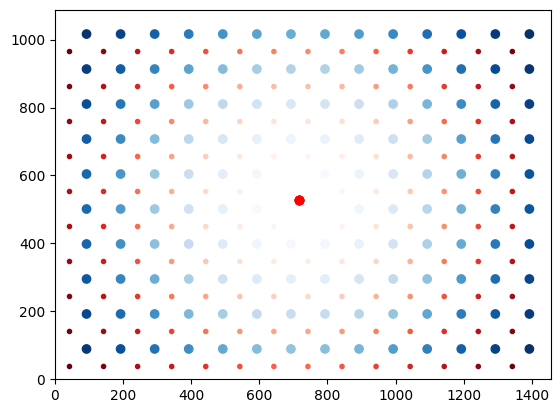

In [5]:
points_ij = fs.wavefront_calibration_points(100, avoid_mirrors=True, plot=True);

#### Multipoint Superpixel Wavefront Calibration

To start, we explore an extension to superpixel-based calibration where we calibrate
many points simultaneously. Using the `calibration_points=None`, the field of view is
densely packed with interference regions which are of appropriate size and of sufficient
separation for the given `superpixel_size`.

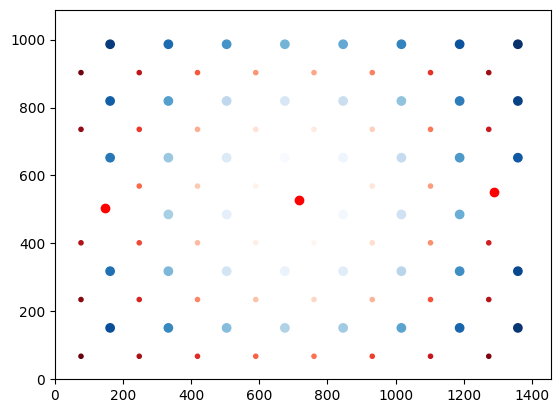

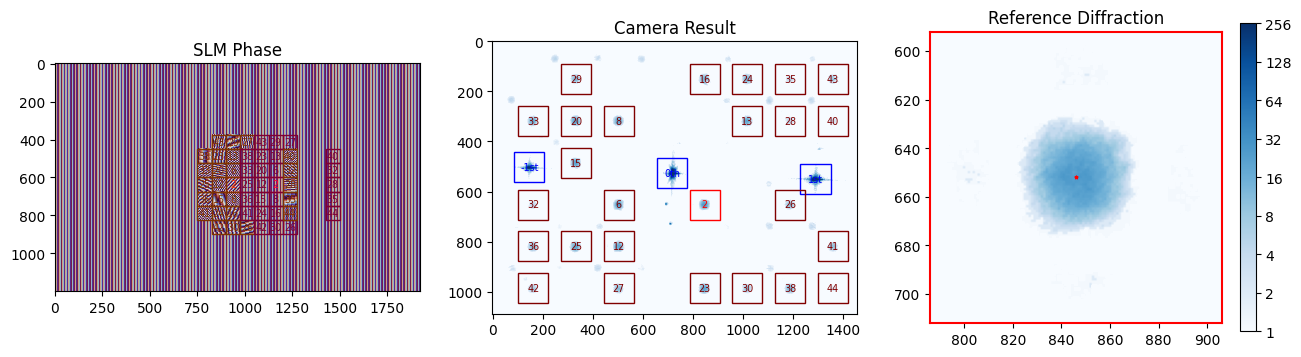

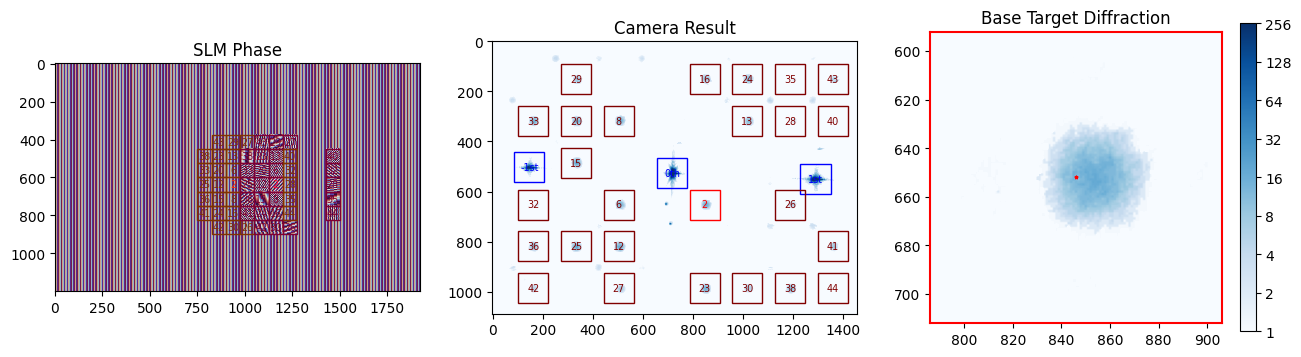

phase_measurement:   0%|          | 0/10 [00:00<?, ?it/s]

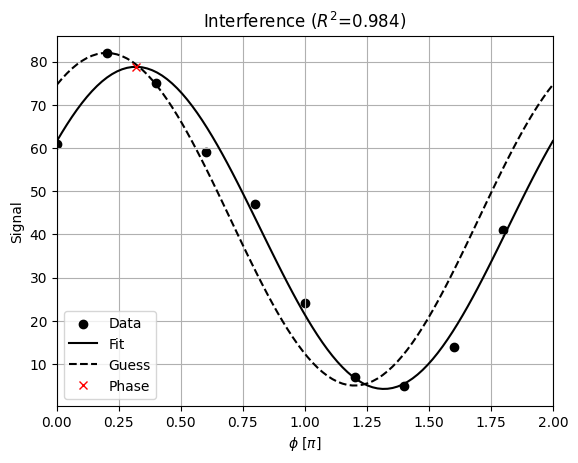

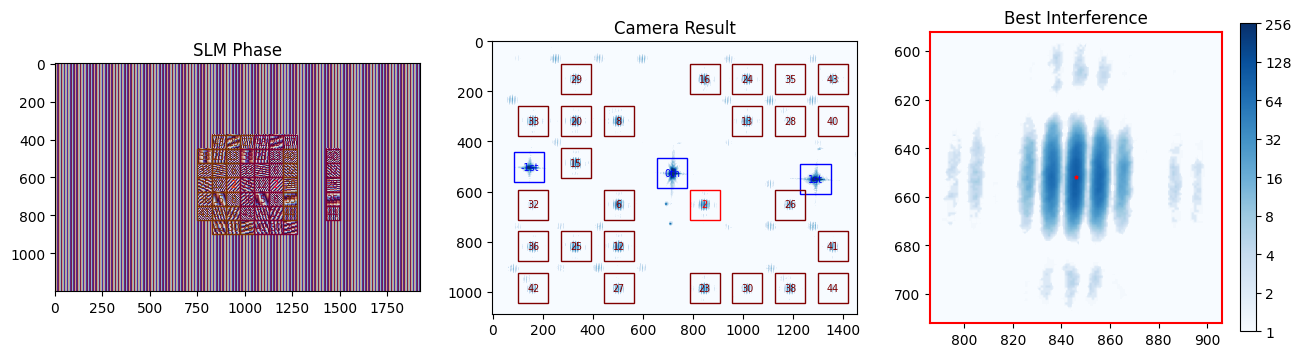

In [ ]:
cam.set_exposure(.1)
movie = fs.wavefront_calibrate_superpixel(
    calibration_points=None,
    field_point=(.25, 0),
    field_point_units="freq",
    superpixel_size=75,
    test_index=2,                       # Testing mode
    phase_steps=10,
    plot=3                              # Special mode to generate a phase .gif
)

from slmsuite.holography.analysis.files import save_image

save_image("wavefront-simutaneous.gif", movie)

We use markdown to display the .gif we just made:

![Phase Movie](wavefront-simutaneous.gif)

Some of the calibration points are not measured during this frame because there is a conflict with
another pair. There's a complex scheduling algorithm running in the background to make sure all pairs
of reference and target superpixels are measured despite these conflicts.

Next, we can perform the calibration.

In [13]:
cam.set_exposure(.1)
fs.wavefront_calibrate_superpixel(
    calibration_points=None,
    field_point=(.25, 0),
    field_point_units="freq",
    superpixel_size=75,
);

The longer runtime is slightly due to scheduling against conflicting superpositions positions,
but mainly due to the overhead of fitting many 2D sinc terms every iteration.
Future optimizations could bring this down to 30 minutes or so.

In [ ]:
fs.save_calibration("wavefront_superpixel")

'C:\\Users\\Experiment\\Documents\\GitHub\\slmsuite-examples\\examples\\02C5V-2018021001-wavefront_superpixel-calibration_00002.h5'

We can use a helper function `_wavefront_calibration_superpixel_plot_raw()` to see what we got.
In our case, the calibrations points at the corners of our field of view have indices `[44, 43, 36, 34]`.

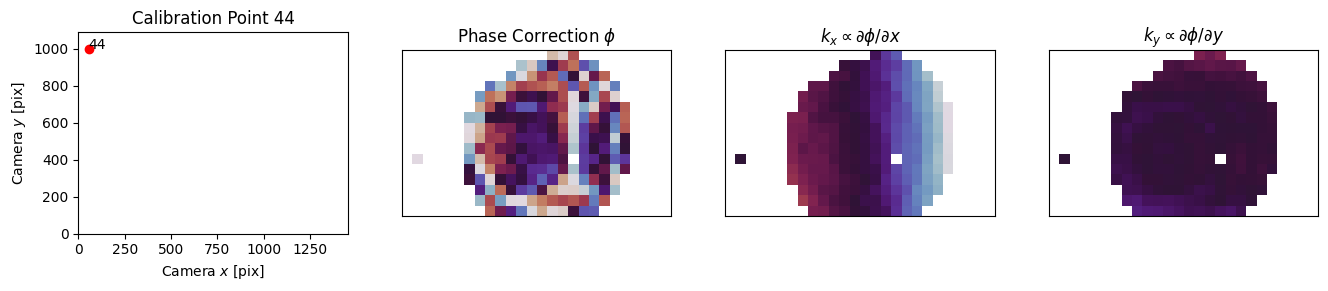

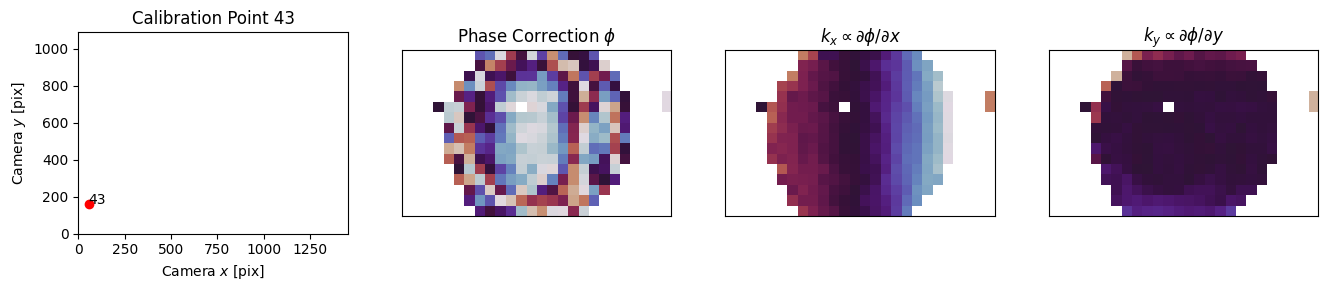

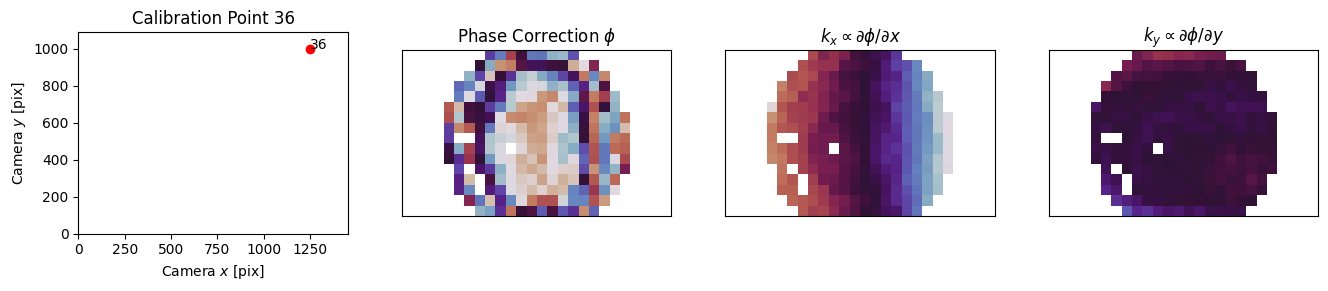

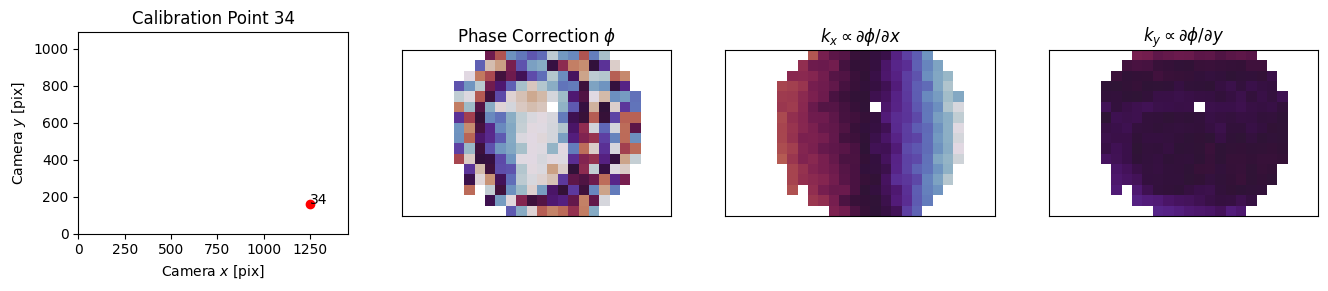

In [65]:
for i in [44, 43, 36, 34]:
    fs._wavefront_calibration_superpixel_plot_raw(index=i, r2_threshold=.5);

This above helper function is currently private and hidden because the analysis routines for this full-field
calibration are not yet finalized. However, the analysis and smoothing for single-point calibration
can still be run by again selecting the proper index.
We don't (currently) have a way to simulate varying aberration across the field of view,
so if you're running virtual hardware you will observe the same aberration at each point.

smooth:   0%|          | 0/16 [00:00<?, ?it/s]

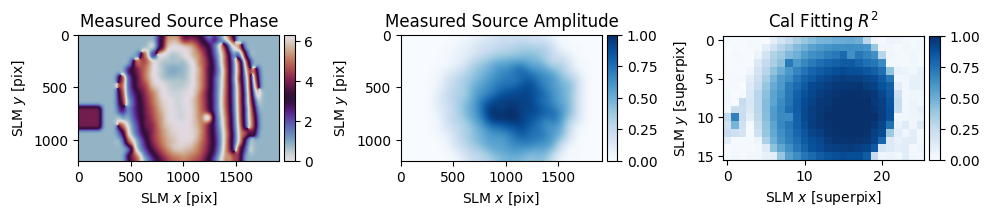

smooth:   0%|          | 0/16 [00:00<?, ?it/s]

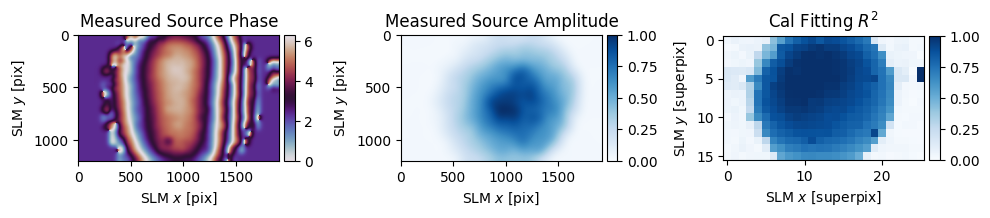

smooth:   0%|          | 0/16 [00:00<?, ?it/s]

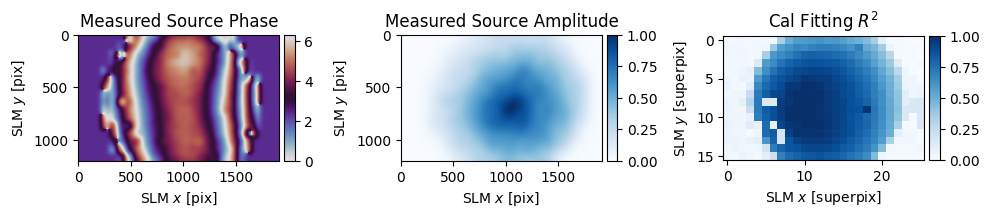

smooth:   0%|          | 0/16 [00:00<?, ?it/s]

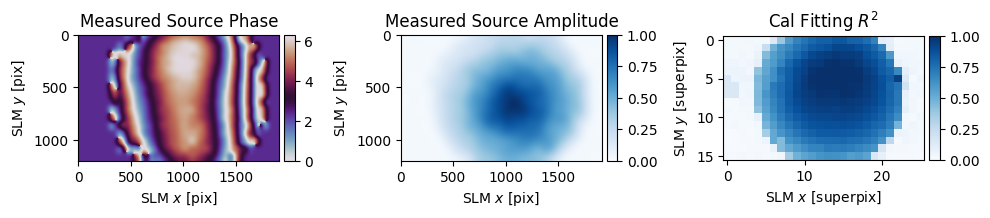

In [60]:
phases = []
for i in [44, 43, 36, 34]:
    dat = fs.wavefront_calibration_superpixel_process(index=i, r2_threshold=.5, smooth=True, plot=True);
    phases.append(dat["phase"])

In our simple setup, most of the aberration comes from the SLM itself, but most of 
the spatially-varying aberration likely comes from the single 150 mm achromatic lens
which separates the SLM from the camera. Even in this very simple setup, we observe 
order 1 wave ($2\pi$) of aberration differece across the field of view.

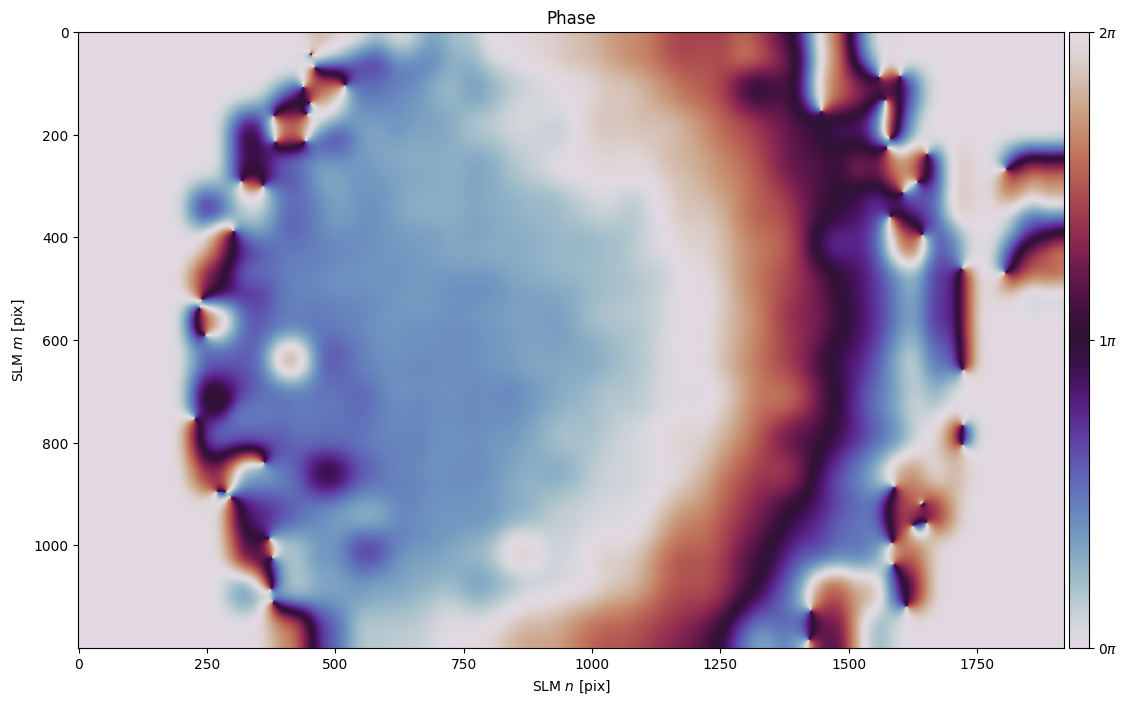

In [66]:
slm.plot(phases[1] - phases[2]);

This problem is exacerbated for high-NA setups
where light is bent to a much larger degree than our simple <.1 NA setup does. As
field of view sizes are pushed larger and larger, our **software solution** to compensating
for aberration becomes increasingly important to close the gap between imperfect aberration mitigation
engineered into the optical train and the ideal of aberration-free imaging.

#### Zernike Wavefront Calibration

With extent of the varying aberration established with the superpixel approach, we can turn our attention to
a faster (and arguable more direct) way to compensate for aberration across many spots.
Let's start by removing the phase calibration
applied to the SLM in the previous section so we can work from the start without correction.

In [ ]:
if "phase" in slm.source: del slm.source["phase"]

We can make use of the Zernike spot optimization explored in the previous example to
directly and iteratively remove aberration from every spot.
The function `.wavefront_calibrate_zernike()` accepts vectors in Zernike-space,
such that the user can provide an arbitrary set of points to correct or further-correct.
We first need to build these vectors from camera coordinates.

In [5]:
from slmsuite.holography.toolbox import convert_vector

points_ij = fs.wavefront_calibration_points(100)

points_zernike = convert_vector(
    points_ij,
    from_units="ij",
    to_units="zernike",
    hardware=fs
)

We can test the Zernike wavefront calibration settings by settings `perturbation=0` (no iterative Zernike perturbation).

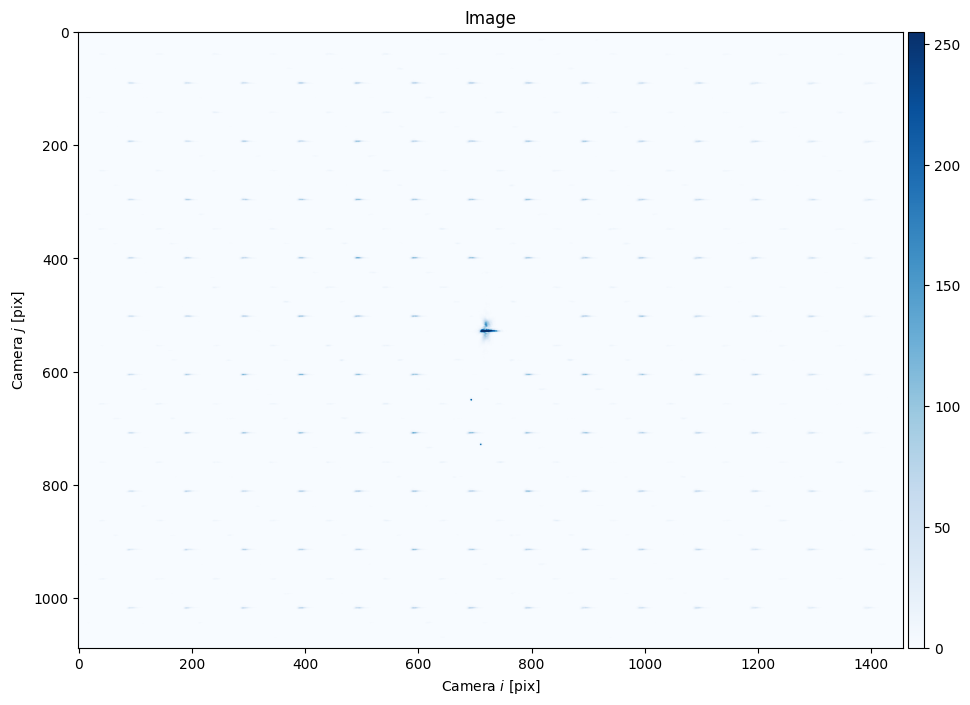

In [6]:
cam.set_exposure(.02)
fs.wavefront_calibrate_zernike(points_zernike, perturbation=0, plot=True)

Now let's actually run the calibration. The `zernike_indices=` argument allows the user to either
say what the desired Zernike basis is or ask for a number of (non-piston) Zernike terms.
The 2D vectors that we're providing are assumed to be the $x,y$ terms and the vectors are zero-padded
to include another 7 terms in Zernike-space, for the 9 indices that we request.

The `perturbation=` argument determines the size of our sweep in radians. For the current code,
using a smallish perturbation and iterating seems to work best, so we will do this.

0it [00:00, ?it/s]

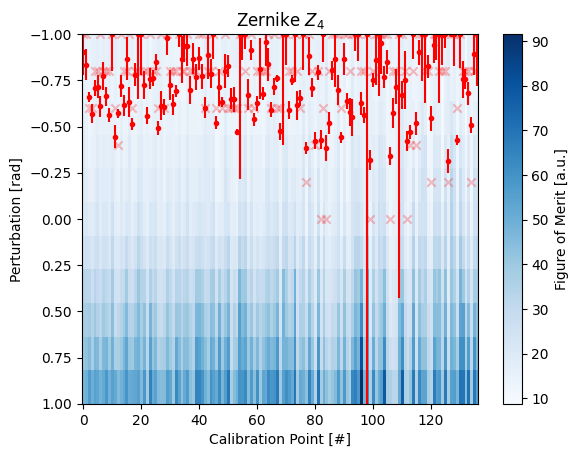

0it [00:00, ?it/s]

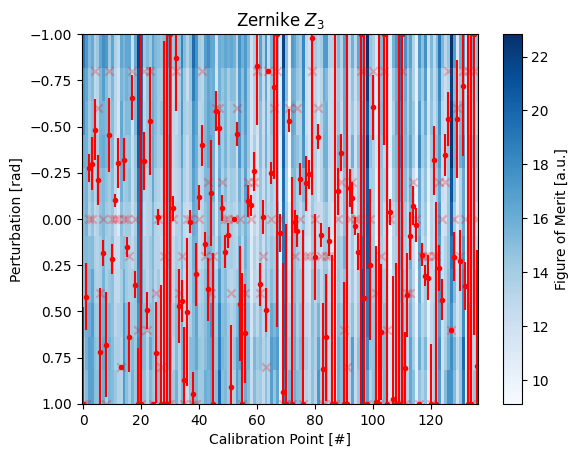

0it [00:00, ?it/s]

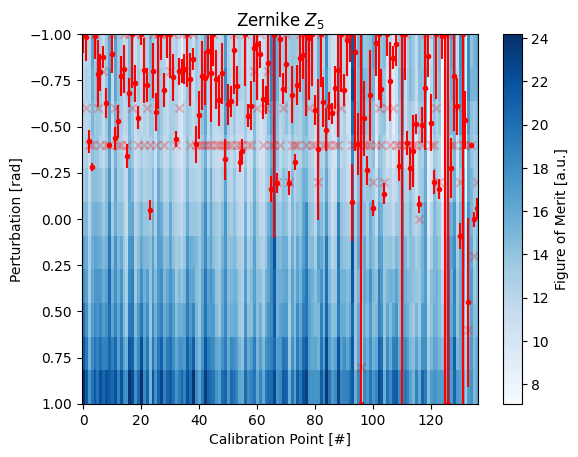

0it [00:00, ?it/s]

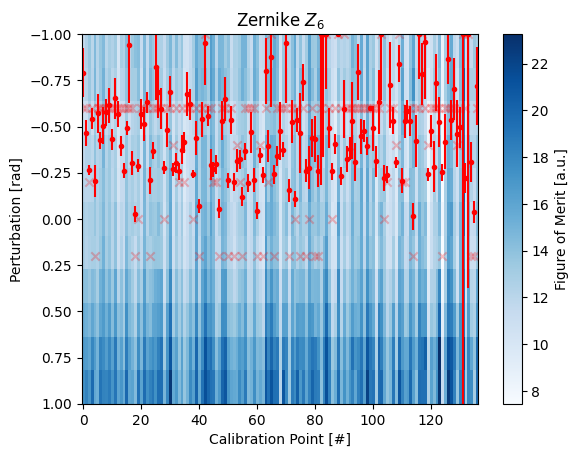

0it [00:00, ?it/s]

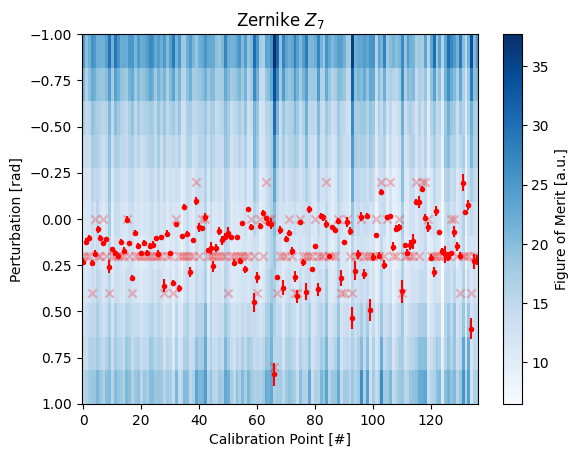

0it [00:00, ?it/s]

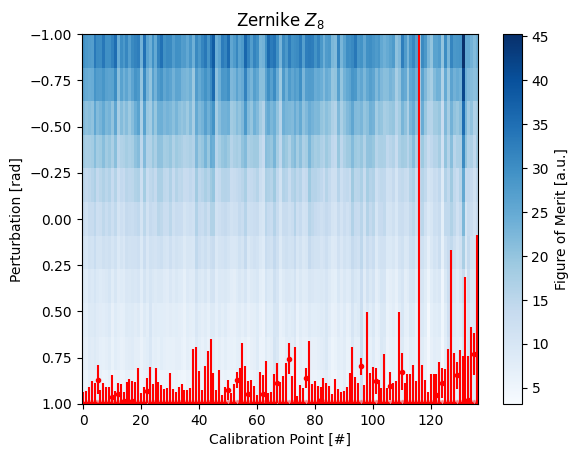

0it [00:00, ?it/s]

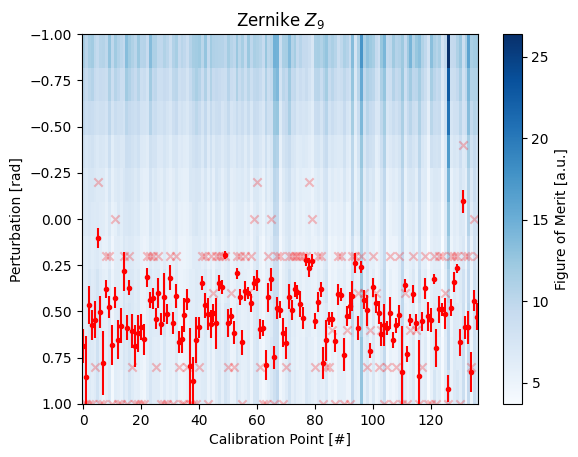

In [7]:
fs.wavefront_calibrate_zernike(points_zernike, zernike_indices=9, perturbation=1, plot=True);

Passing `None` in place of the points tells `.wavefront_calibrate_zernike()` to use the result of the 
previous calibration, so this is an easy way to iterate the calibration.
Let's do a few more iterations (but forego the plots except for on the last one):

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

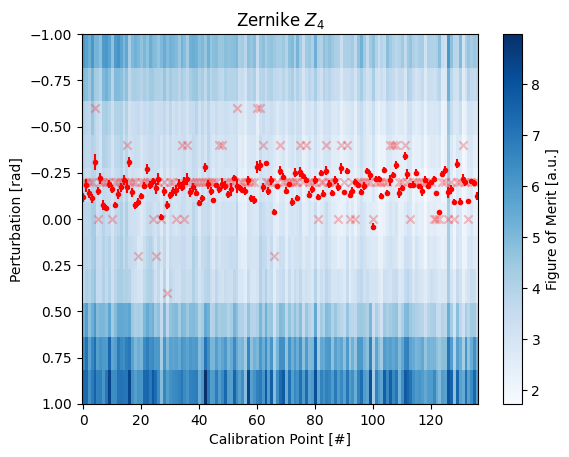

0it [00:00, ?it/s]

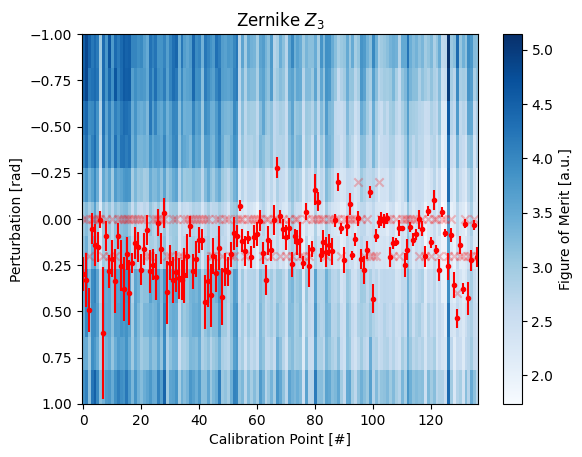

0it [00:00, ?it/s]

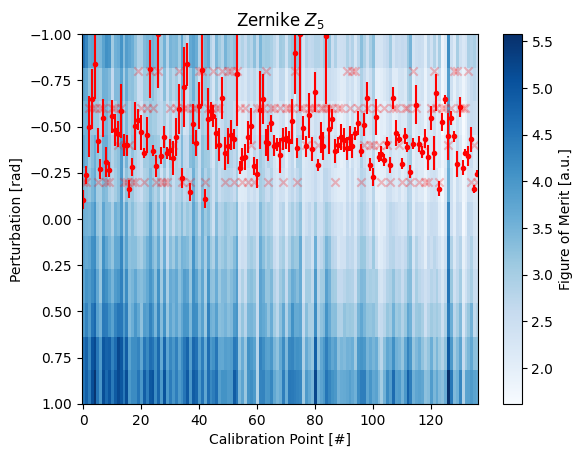

0it [00:00, ?it/s]

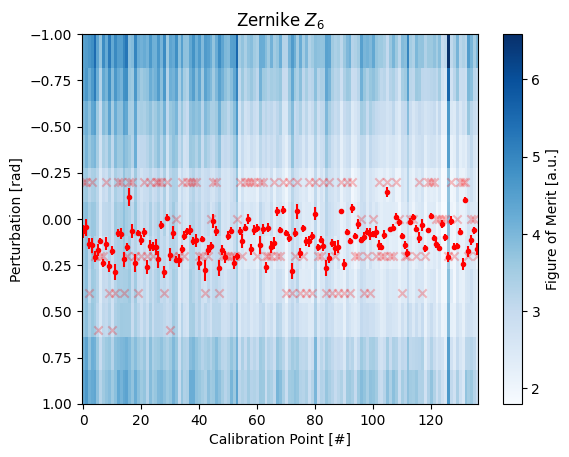

0it [00:00, ?it/s]

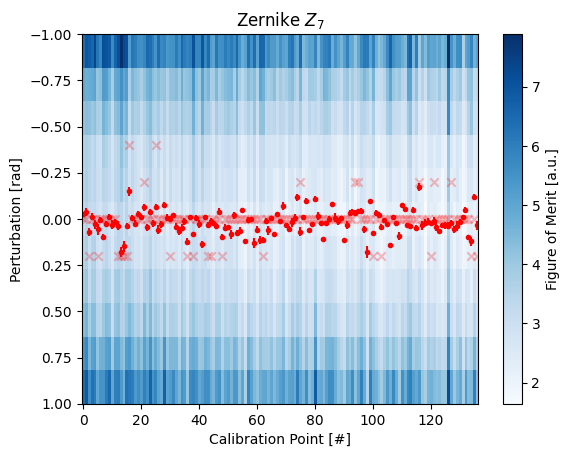

0it [00:00, ?it/s]

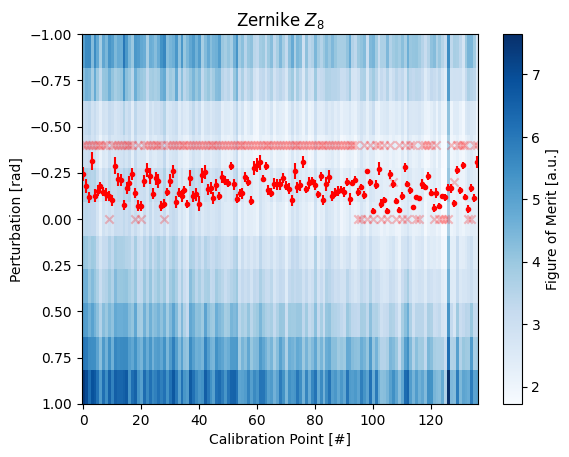

0it [00:00, ?it/s]

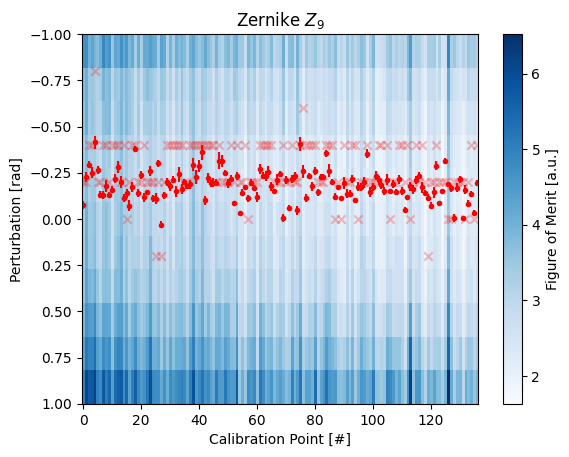

In [8]:
N = 4

for i in range(N):
    fs.wavefront_calibrate_zernike(None, zernike_indices=9, perturbation=1, plot=(i == N-1))

The optimization currently takes several iterations, in part because of imperfect
orthonormality of the Zernike terms. What we want to see (and do see) is stability
in the convergence at the end of the optimization.
We see stability to around <.2 radians, or about 30 miliwaves per term.
Virtual hardware is able to get to <.1 radians fairly easily.
Additionally, having a decent guess of the initial aberration, whether by 
Zernike fit to the superpixel wavefront calibration or `fastphase`,
can help the optimization to find an early minimum.

We can take a look at the final results by plotting the data directly:

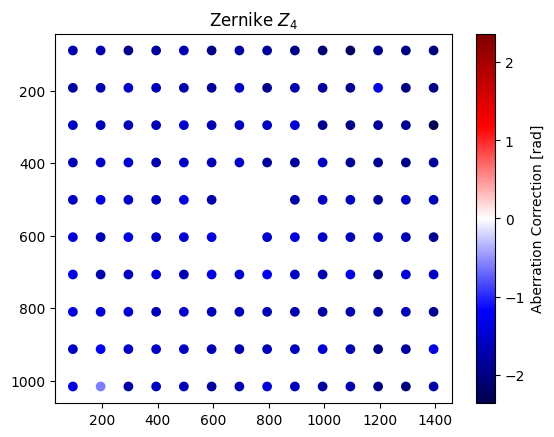

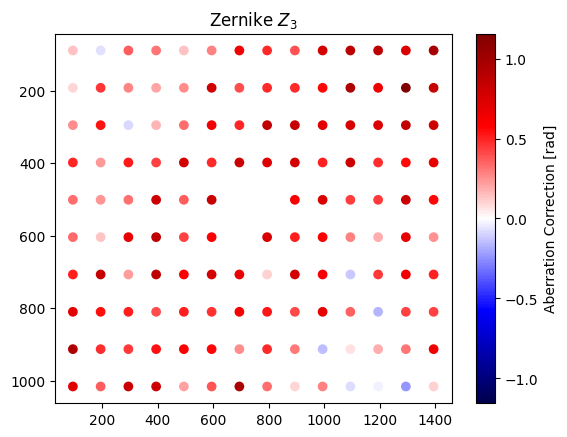

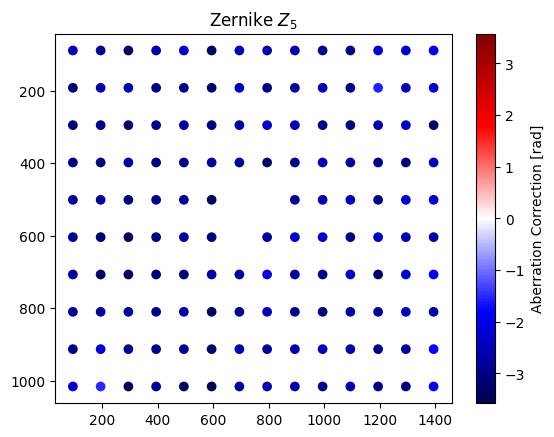

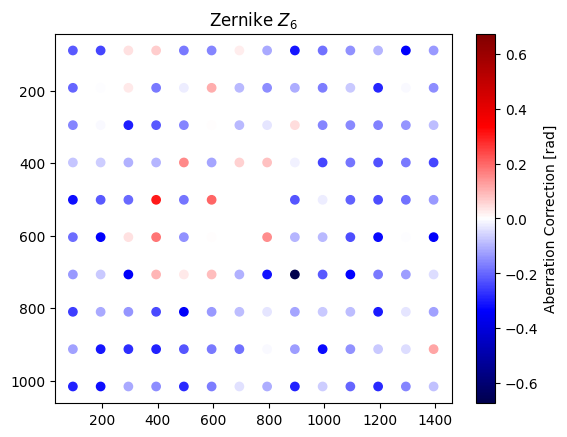

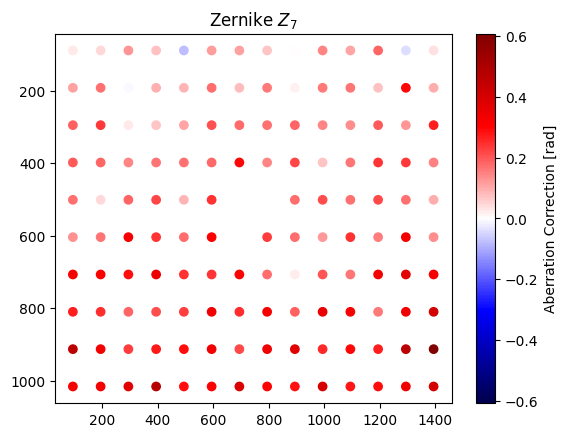

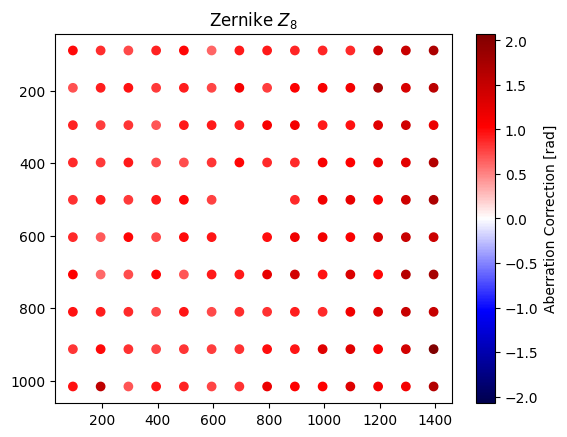

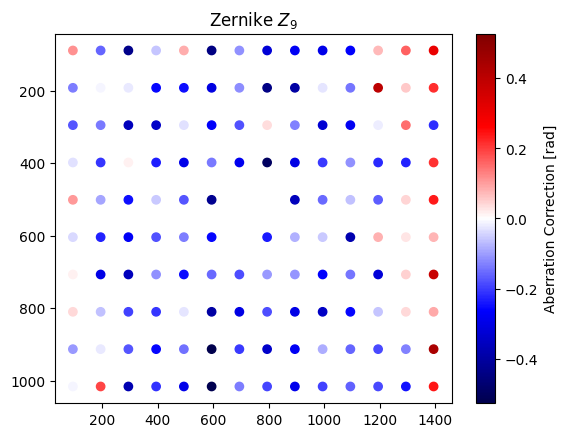

In [ ]:
for index in range(2,9):
    fs._wavefront_calibrate_zernike_plot_raw(index)
    plt.show()

We can also examine the image directly, by again using `perturbation=0` as a proxy:

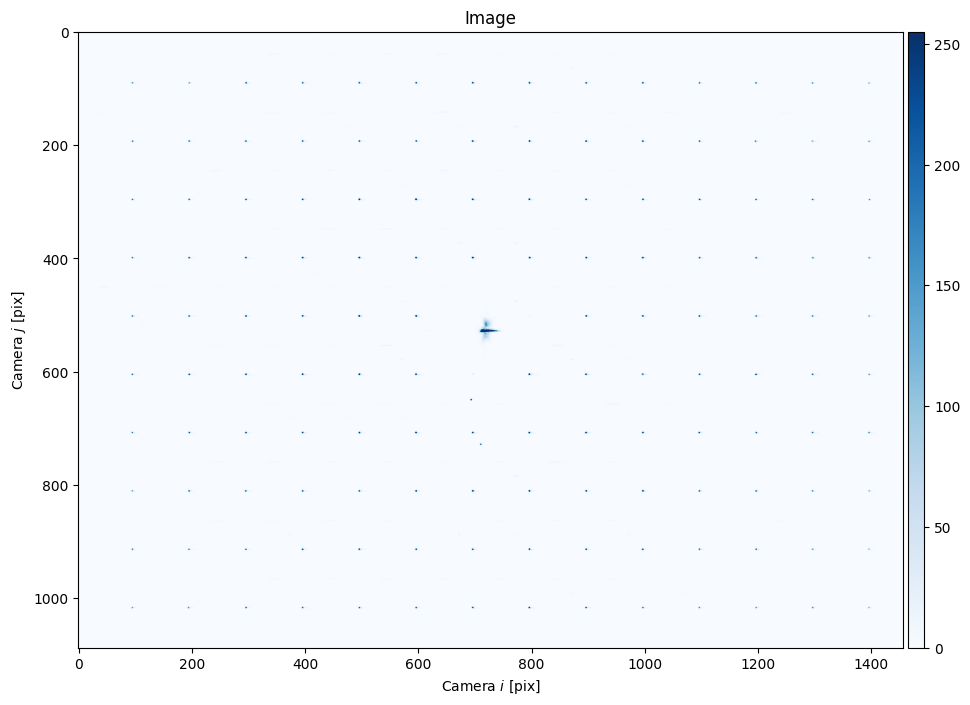

In [10]:
fs.wavefront_calibrate_zernike(None, zernike_indices=9, perturbation=0, plot=True)

Nice, tight spots.

It's also important to mention that this method is extremely general.
`.wavefront_calibrate_zernike()` accepts user-provided functions to change
the `metric=` of how spot images from the camera are judged, or completely
change the heuristic by providing a custom `callback=`.

- The `metric()` takes in a stack of spot images, each image corresponding to
  one spot, and is respected to return a list of the goodness of each image.
- `callback()` overrides camera functionality and the user can choose how to
  determine the goodness. This, for instance, could be a measure of trap depth
  on atoms or similar measurement that avoids aberration between the camera and
  an experimental plane. After all, perfect spots on the camera might correspond
  to very distorted spots in an experimental plane.

Future additions to `slmsuite` will take greater advantage of this 
full-field calibration information. We look forward to seeing how far
we can push this frontier!